{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
gold
0    1372
1    1021
2     285
3      66
4      30
5       5
6       1
7       1
Name: count, dtype: int64
Using k_neighbors=4 for SMOTE
silver
0     1691
1      738
2      227
3       62
4       28
5       14
6        9
8        6
7        4
9        1
10       1
Name: count, dtype: int64
Using k_neighbors=3 for SMOTE
bronze
0    1547
1     905
2     247
3      48
4      19
5       8
6       3
7       2
9       1
8       1
Name: count, dtype: int64
Using k_neighbors=1 for SMOTE


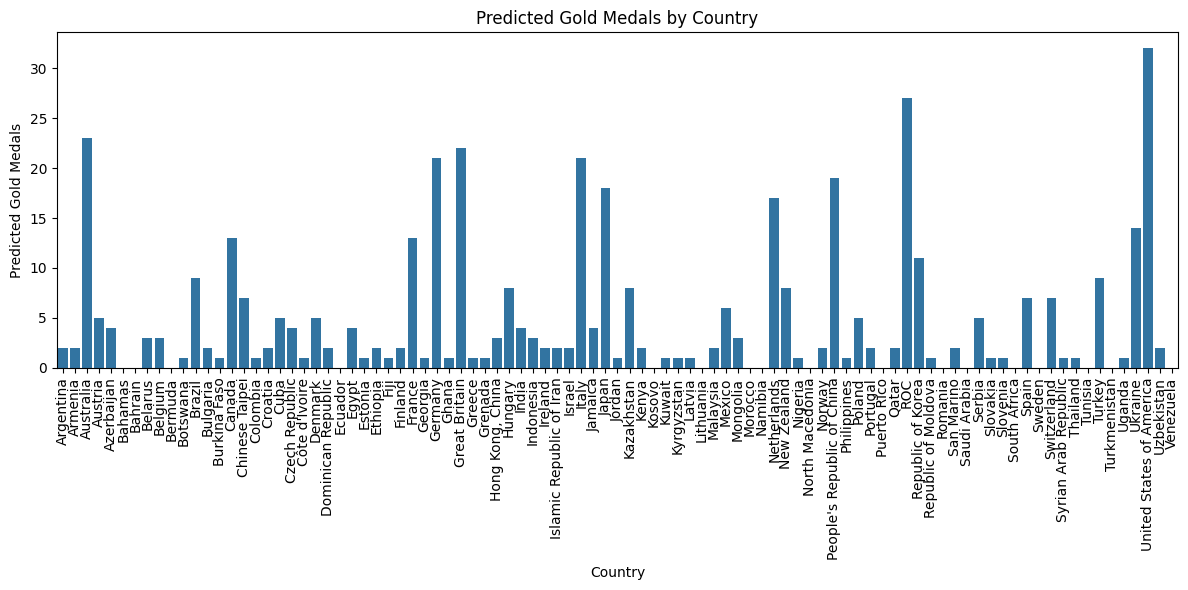

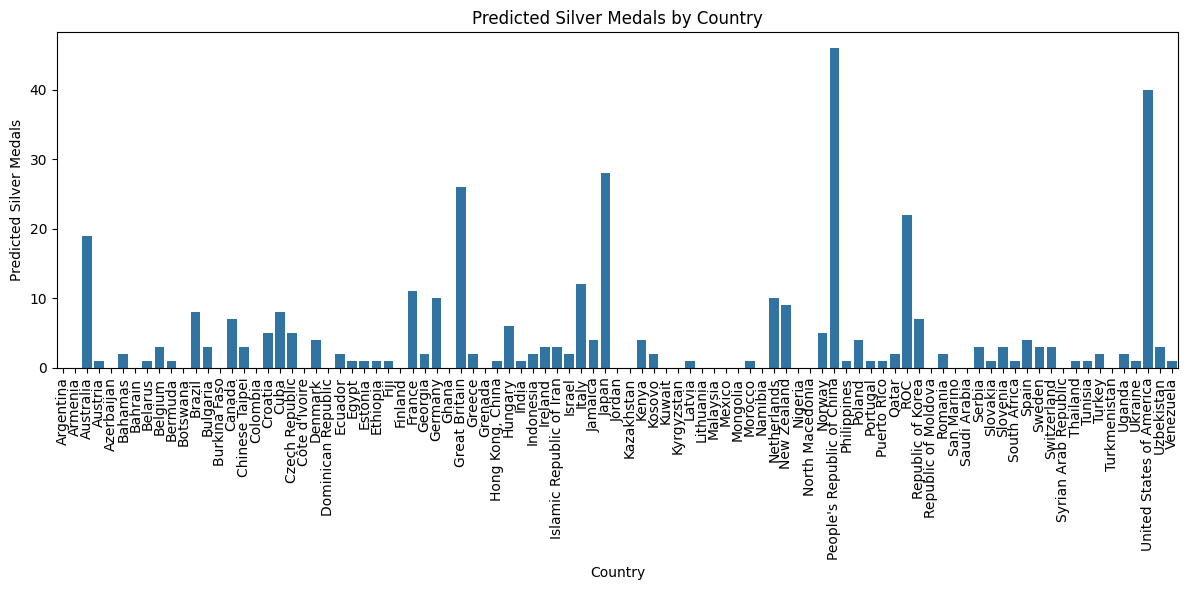

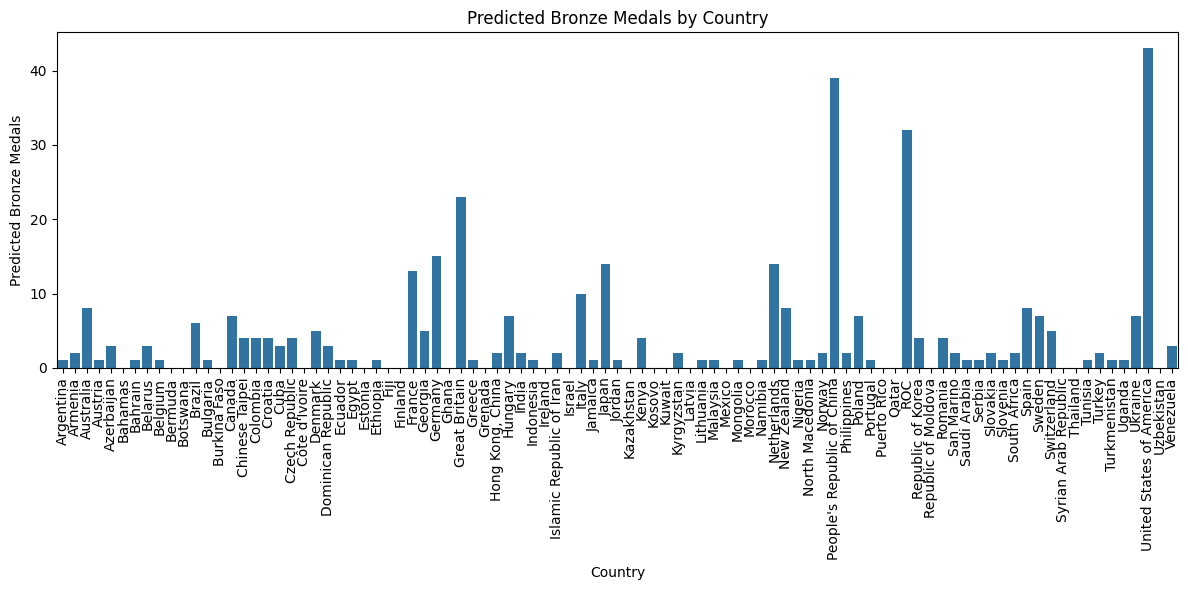

Uploading an estimated of 1 files
Uploading predicted_olympic_medals.csv
Uploaded predicted_olympic_medals.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Predicted medals saved to predicted_olympic_medals.csv
total
1     1602
2      619
3      255
4      122
5       84
6       37
7       19
8       13
9        8
14       5
16       4
10       3
18       2
12       2
15       2
17       2
19       1
13       1
Name: count, dtype: int64
Using k_neighbors=1 for SMOTE


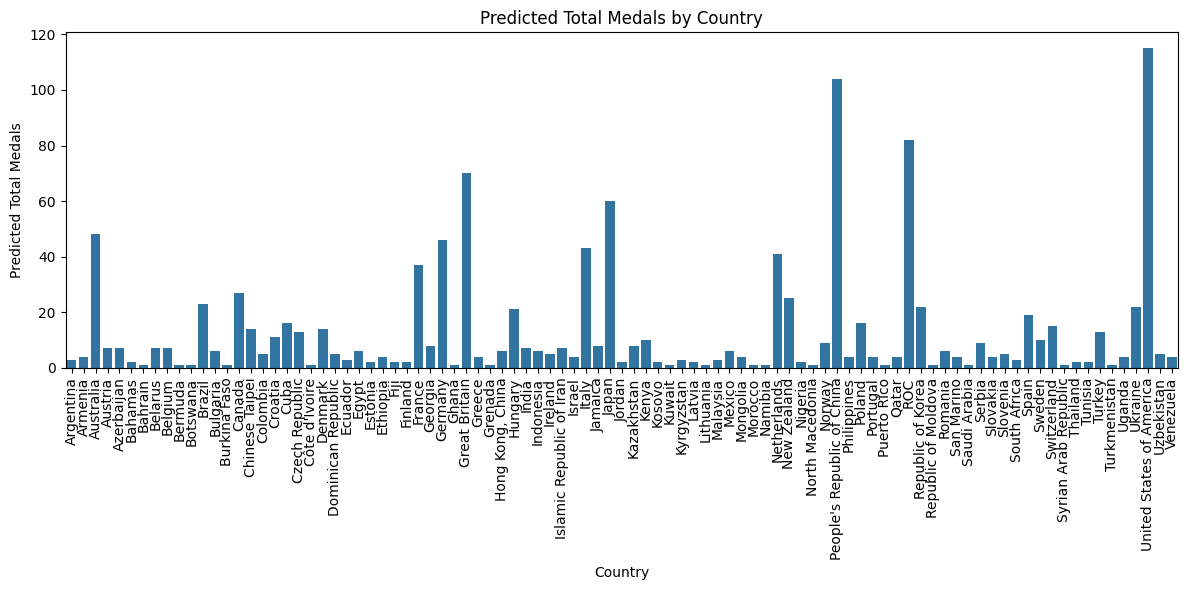

Predicted total medals saved to predicted_total_medals.csv
      country  Predicted_Total
0   Argentina                3
1     Armenia                4
2   Australia               48
3     Austria                7
4  Azerbaijan                7


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from azureml.core import Workspace, Dataset

# Load the dataset
ws = Workspace.from_config()
datastore = ws.get_default_datastore()
dataset = Dataset.Tabular.from_delimited_files(path=(datastore, '/olympic_medals.csv'), validate=False)
df = dataset.to_pandas_dataframe()

# file_path = 'olympic_medals.csv'
# df = pd.read_csv(file_path)

# Filter for Summer Olympics and the years 2004, 2008, 2012, 2016, and 2020
summer_years = ['athens-2004', 'beijing-2008', 'london-2012', 'rio-2016', 'tokyo-2020']
df_summer = df[df['slug_game'].isin(summer_years)].copy()

# Extract the year from the 'slug_game' column and create a new 'year' column
df_summer['year'] = df_summer['slug_game'].str.extract(r'(\d{4})').astype(int)

# Create a pivot table to count the medals by country, discipline, year, and gender
medal_counts = df_summer.pivot_table(index=['country_name', 'discipline_title', 'year', 'event_gender'],
                                     columns='medal_type',
                                     aggfunc='size',
                                     fill_value=0).reset_index()

# Calculate the total number of medals
medal_counts['total'] = medal_counts[['GOLD', 'SILVER', 'BRONZE']].sum(axis=1)

# Rename columns for clarity
medal_counts.columns = ['country', 'discipline', 'year', 'event_gender', 'gold', 'silver', 'bronze', 'total']

# Prepare features and target
X = medal_counts[['year', 'gold', 'silver', 'bronze', 'event_gender']].copy()

# Convert gender to numeric values for the model
event_gender_mapping = {'Men': 1, 'Women': 0, 'Mixed': 2}
X['event_gender'] = X['event_gender'].map(event_gender_mapping)

y_gold = medal_counts['gold']
y_silver = medal_counts['silver']
y_bronze = medal_counts['bronze']
y_total = medal_counts['total']

# Handle missing values
X = X.fillna(X.mean()).infer_objects(copy=False)

# Normalize the data
scaler = StandardScaler()
X[['year', 'gold', 'silver', 'bronze']] = scaler.fit_transform(X[['year', 'gold', 'silver', 'bronze']])

# Function to train and predict medals
def train_and_predict(y, medal_type):
    # Check the distribution of the target variable
    print(y.value_counts())

    # Filter out classes with fewer than 2 samples
    valid_classes = y.value_counts()[y.value_counts() > 1].index
    valid_indices = y.isin(valid_classes)
    X_valid = X[valid_indices].copy()
    y_valid = y[valid_indices]

    # Handle imbalanced data using SMOTEENN
    min_samples = min(y_valid.value_counts())
    k_neighbors = max(1, min_samples - 1)
    print(f"Using k_neighbors={k_neighbors} for SMOTE")

    smote = SMOTE(k_neighbors=k_neighbors)
    smote_enn = SMOTEENN(random_state=42, smote=smote)
    X_resampled, y_resampled = smote_enn.fit_resample(X_valid, y_valid)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Train the RandomForest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict future medals for the next Olympics
    next_olympics_year = 2024
    latest_year_data = medal_counts[medal_counts['year'] == medal_counts['year'].max()].copy()
    latest_year_data['year'] = next_olympics_year  # Update the year

    # Map gender values to numeric for the prediction
    latest_year_data['event_gender'] = latest_year_data['event_gender'].map(event_gender_mapping)

    # Normalize the prediction data
    latest_year_data[['year', 'gold', 'silver', 'bronze']] = scaler.transform(latest_year_data[['year', 'gold', 'silver', 'bronze']])

    future_predictions = model.predict(latest_year_data[['year', 'gold', 'silver', 'bronze', 'event_gender']])

    latest_year_data[f'Predicted_{medal_type}'] = future_predictions

    return latest_year_data[['country', 'discipline', 'event_gender', f'Predicted_{medal_type}']]

# Predict gold, silver, and bronze medals
predicted_gold = train_and_predict(y_gold, 'Gold')
predicted_silver = train_and_predict(y_silver, 'Silver')
predicted_bronze = train_and_predict(y_bronze, 'Bronze')

# Combine predictions
predicted_data = pd.merge(predicted_gold, predicted_silver, on=['country', 'discipline', 'event_gender'])
predicted_data = pd.merge(predicted_data, predicted_bronze, on=['country', 'discipline', 'event_gender'])

# Convert gender back to categorical for better visualization
event_gender_mapping_reverse = {1: 'Men', 0: 'Women', 2: 'Mixed'}
predicted_data['event_gender'] = predicted_data['event_gender'].map(event_gender_mapping_reverse)

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=predicted_data.groupby('country')['Predicted_Gold'].sum().reset_index(), x='country', y='Predicted_Gold')
plt.title('Predicted Gold Medals by Country')
plt.xticks(rotation=90)
plt.ylabel('Predicted Gold Medals')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=predicted_data.groupby('country')['Predicted_Silver'].sum().reset_index(), x='country', y='Predicted_Silver')
plt.title('Predicted Silver Medals by Country')
plt.xticks(rotation=90)
plt.ylabel('Predicted Silver Medals')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=predicted_data.groupby('country')['Predicted_Bronze'].sum().reset_index(), x='country', y='Predicted_Bronze')
plt.title('Predicted Bronze Medals by Country')
plt.xticks(rotation=90)
plt.ylabel('Predicted Bronze Medals')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

# Save the predictions to a CSV file
local_path = 'predicted_olympic_medals.csv'
predicted_data.to_csv('predicted_olympic_medals.csv', index=False)
datastore.upload_files(files=[local_path], target_path='predictions/', overwrite=True, show_progress=True)
print('Predicted medals saved to predicted_olympic_medals.csv')

# Predict total medals
def train_and_predict_total():
    # Check the distribution of the target variable
    print(y_total.value_counts())

    # Filter out classes with fewer than 2 samples
    valid_classes = y_total.value_counts()[y_total.value_counts() > 1].index
    valid_indices = y_total.isin(valid_classes)
    X_valid = X[valid_indices].copy()
    y_valid = y_total[valid_indices]

    # Handle imbalanced data using SMOTEENN
    min_samples = min(y_valid.value_counts())
    k_neighbors = max(1, min_samples - 1)
    print(f"Using k_neighbors={k_neighbors} for SMOTE")

    smote = SMOTE(k_neighbors=k_neighbors)
    smote_enn = SMOTEENN(random_state=42, smote=smote)
    X_resampled, y_resampled = smote_enn.fit_resample(X_valid, y_valid)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Train the RandomForest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict future medals for the next Olympics
    next_olympics_year = 2024
    latest_year_data = medal_counts[medal_counts['year'] == medal_counts['year'].max()].copy()
    latest_year_data['year'] = next_olympics_year  # Update the year

    # Map gender values to numeric for the prediction
    latest_year_data['event_gender'] = latest_year_data['event_gender'].map(event_gender_mapping)

    # Normalize the prediction data
    latest_year_data[['year', 'gold', 'silver', 'bronze']] = scaler.transform(latest_year_data[['year', 'gold', 'silver', 'bronze']])

    future_predictions = model.predict(latest_year_data[['year', 'gold', 'silver', 'bronze', 'event_gender']])

    # Round the predictions to the nearest integer
    latest_year_data['Predicted_Total'] = future_predictions.round().astype(int)

    return latest_year_data[['country', 'Predicted_Total']]

# Predict total medals
predicted_total = train_and_predict_total()

# Aggregate the predicted totals by country
predicted_total_by_country = predicted_total.groupby('country')['Predicted_Total'].sum().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=predicted_total_by_country, x='country', y='Predicted_Total')
plt.title('Predicted Total Medals by Country')
plt.xticks(rotation=90)
plt.ylabel('Predicted Total Medals')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

# Save the predictions to a CSV file
local_path = 'predicted_total_medals.csv'
predicted_total_by_country.to_csv('predicted_total_medals.csv', index=False)
datastore.upload_files(files=[local_path], target_path='predictions/', overwrite=True, show_progress=True)
print('Predicted total medals saved to predicted_total_medals.csv')

# Display the first few rows of the final data to verify the output
print(predicted_total_by_country.head())

# Function to show medals (gold, silver, bronze) of a selected country
def show_country_medals(country):
    country_data = predicted_data[predicted_data['country'] == country].groupby('country').sum().reset_index()
    if country_data.empty:
        print(f"No data available for {country}.")
        return
    plt.figure(figsize=(8, 6))
    sns.barplot(x=['Gold', 'Silver', 'Bronze'], y=[country_data['Predicted_Gold'][0], country_data['Predicted_Silver'][0], country_data['Predicted_Bronze'][0]])
    plt.title(f'Predicted Medals for {country}')
    plt.ylabel('Number of Medals')
    plt.xlabel('Medal Type')
    plt.tight_layout()
    plt.show()

# Get input from user for country and show medals
selected_country = input("Enter the country name: ")
show_country_medals(selected_country)
